# Loss VS angle

Is the error bigger for slower speeds for the non-extreme angle values?

This notebook puts the losses to angle range bins and compares the average losses of different angle ranges over the datasets with different speeds

## Load data

In [33]:
import pandas as pd

df = pd.read_csv('3D-CNN-model-results.csv.gz')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324050 entries, 0 to 324049
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   name                324050 non-null  object 
 1   direction           324050 non-null  object 
 2   speed               324050 non-null  float64
 3   fold                324050 non-null  int64  
 4   is_train            324050 non-null  bool   
 5   predicted_angle     324050 non-null  float64
 6   ground_truth_angle  324050 non-null  float64
dtypes: bool(1), float64(3), int64(1), object(2)
memory usage: 15.1+ MB


In [34]:
grouping_features = ['name']
df[df.fold == 1].groupby(grouping_features).ground_truth_angle.count()

name
1-1-CC-80     2998
1-2-CC-90     4542
1-3-CC-85     4272
2-1-CW-80     4431
2-2-CW-90     1235
2-3-CW-85     6086
3-2-CW-90     5217
3-3-CW-85     4006
4-1-CC-80     4705
4-2-CC-90     5963
4-3-CC-85     4398
test90        3392
train90      13565
Name: ground_truth_angle, dtype: int64

## Average angles for predicted and ground truth angles for each tub

In [35]:
grouping_features = ['direction', 'speed', 'name', 'is_train']
df.groupby(grouping_features).predicted_angle.mean()

direction  speed  name       is_train
CC         0.80   1-1-CC-80  False      -0.215689
                  4-1-CC-80  False      -0.199210
           0.85   1-3-CC-85  False      -0.201251
                  4-3-CC-85  False      -0.206147
           0.90   1-2-CC-90  True       -0.193683
                  4-2-CC-90  True       -0.193361
                  test90     False      -0.188448
                  train90    True       -0.194763
CW         0.80   2-1-CW-80  False       0.415180
           0.85   2-3-CW-85  False       0.391129
                  3-3-CW-85  False       0.406064
           0.90   2-2-CW-90  True        0.389557
                  3-2-CW-90  True        0.384088
                  test90     False       0.384819
                  train90    True        0.385213
Name: predicted_angle, dtype: float64

In [36]:
df.groupby(grouping_features).ground_truth_angle.mean()

direction  speed  name       is_train
CC         0.80   1-1-CC-80  False      -0.217514
                  4-1-CC-80  False      -0.217245
           0.85   1-3-CC-85  False      -0.213445
                  4-3-CC-85  False      -0.232535
           0.90   1-2-CC-90  True       -0.279574
                  4-2-CC-90  True       -0.253783
                  test90     False      -0.264934
                  train90    True       -0.264934
CW         0.80   2-1-CW-80  False       0.344451
           0.85   2-3-CW-85  False       0.368073
                  3-3-CW-85  False       0.336757
           0.90   2-2-CW-90  True        0.344306
                  3-2-CW-90  True        0.394307
                  test90     False       0.384736
                  train90    True        0.384736
Name: ground_truth_angle, dtype: float64

## Arrange all data points into 11 bins based on ground truth angle and predicted angle

In [37]:
import numpy as np
df['squared_error'] = np.square(df.predicted_angle - df.ground_truth_angle)
out, bins = pd.cut(df.ground_truth_angle, bins=11, retbins=True)
out = out.reset_index(drop = True)
df['gt_bin'] = out

bins[0] -=1
bins[-1] += 1
df['pred_bin'] = pd.cut(df.predicted_angle, bins=bins, include_lowest=True).reset_index(drop = True)

In [38]:
sum(df['pred_bin'].isna())

0

In [39]:
cc_df = df[(df.direction == 'CC') & (df.is_train == False)]
cc_df.groupby(['speed']).mean()

,fold,is_train,predicted_angle,ground_truth_angle,squared_error
speed,,,,,
0.80,3,False,-0.205624,-0.217350,0.104215
0.85,3,False,-0.203735,-0.223128,0.100153
0.90,3,False,-0.188448,-0.264934,0.128300


In [40]:

df[(df.direction == 'CC') & (df.is_train == True)].groupby(['speed']).mean()

,fold,is_train,predicted_angle,ground_truth_angle,squared_error
speed,,,,,
0.9,3,True,-0.194062,-0.264934,0.124217


In [41]:
df[(df.direction == 'CC')].groupby(['speed', 'is_train']).mean()[['squared_error']]

squared_error
speed is_train               
0.80  False          0.104215
0.85  False          0.100153
0.90  False          0.128300
      True           0.124217

In [42]:
from matplotlib import pyplot as plt

def autolabel(rects, ax=None):
    if ax:
        plotting = ax
    else:
        plotting = plt
    for rect in rects:
        height = rect.get_height()
        plotting.text(rect.get_x() + rect.get_width()/2., 1.01*height, int(height*1000)/1000, ha='center', va='bottom')


## Plot histograms for ground truth and predictions for all 3 speeds for Counter Clockwise direction

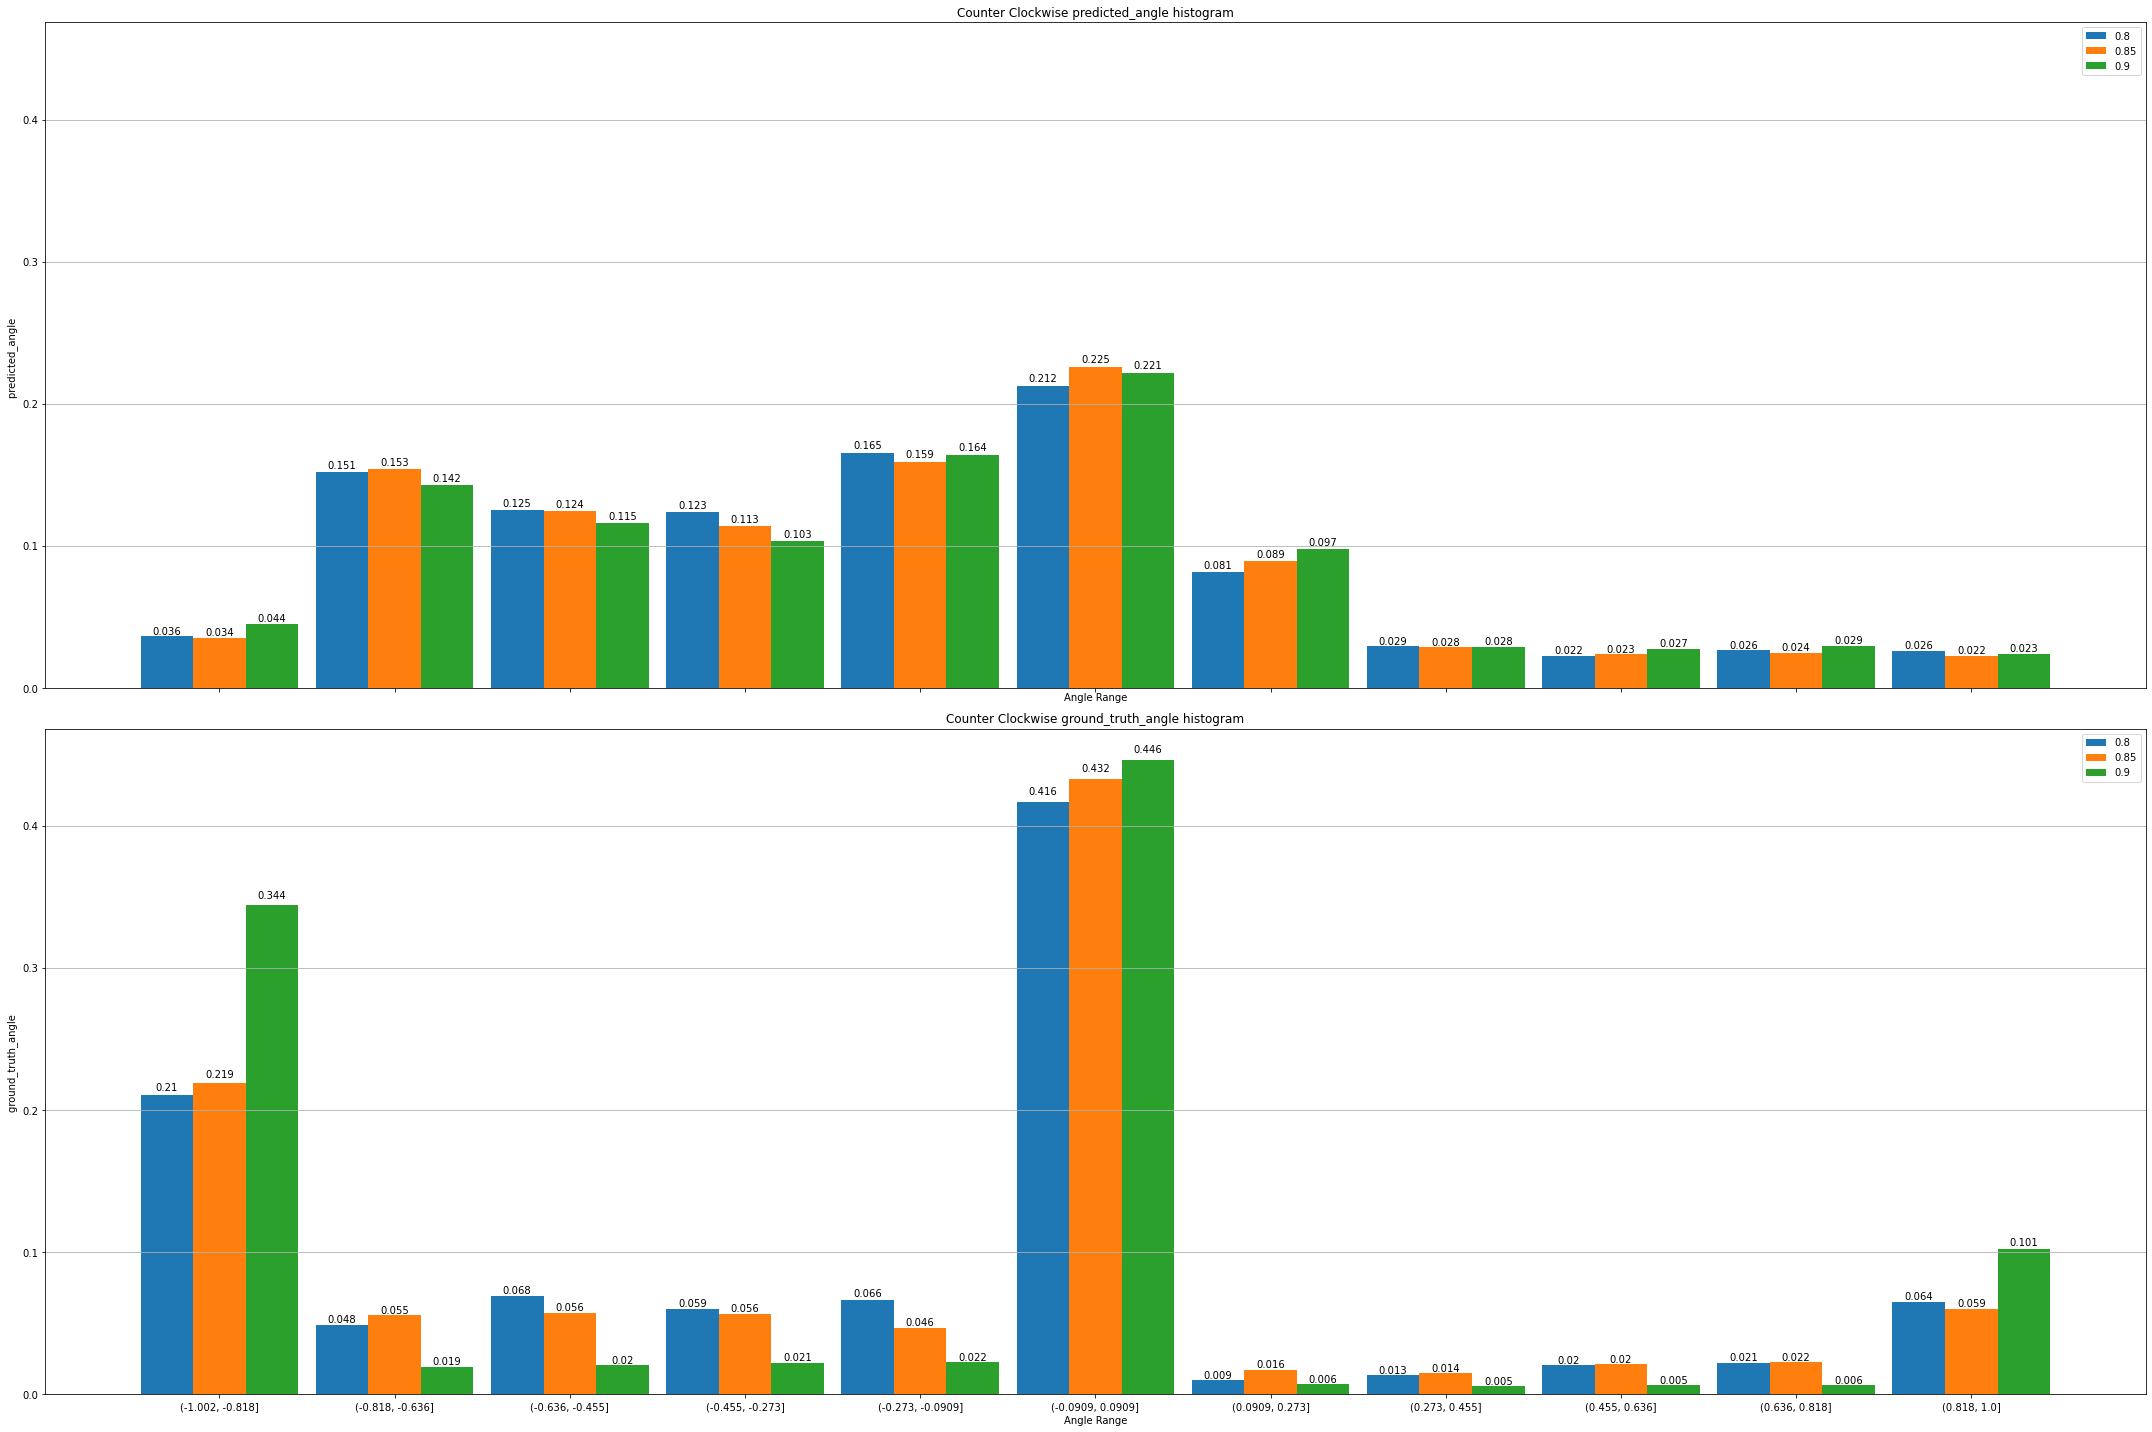

In [43]:
def plot_all_speed_histograms(ax, df: pd.DataFrame, direction: str, y_column_name: str, x_column_name: str):
    ind = np.arange(df.gt_bin.unique().size)
    width = 0.3

    for i, speed in enumerate([0.8, 0.85, 0.9]):
        speed_df = df[df.speed == speed]
        grouped = speed_df.groupby(x_column_name)
        total_count = speed_df[y_column_name].count()
        group_count = grouped[y_column_name].count()
        ratios = group_count / total_count
        rects = ax.bar(i*width+ind, ratios, label=speed, width=width)
        autolabel(rects, ax)

    ax.set(title=f'{direction} {y_column_name} histogram',
           ylabel=f'{y_column_name} ',
           xlabel='Angle Range',
           xticks = ind + width,
           xticklabels = ratios.index)

    ax.legend(loc='best')

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(30, 20), sharex='all', sharey='all')
for colnames, ax in zip([('predicted_angle', 'pred_bin'), ('ground_truth_angle', 'gt_bin')], axs.flat):
    ax.grid(True, axis='y')
    plot_all_speed_histograms(ax, cc_df, 'Counter Clockwise', colnames[0], colnames[1])

    ax.legend()
fig.tight_layout()
plt.show()

## Plot squared error ratio for each bin for Counter Clockwise data
For example, the sum of 0.9-speed squared error ratios of all 11 bins is 1. Same for 0.85 and 0.8.

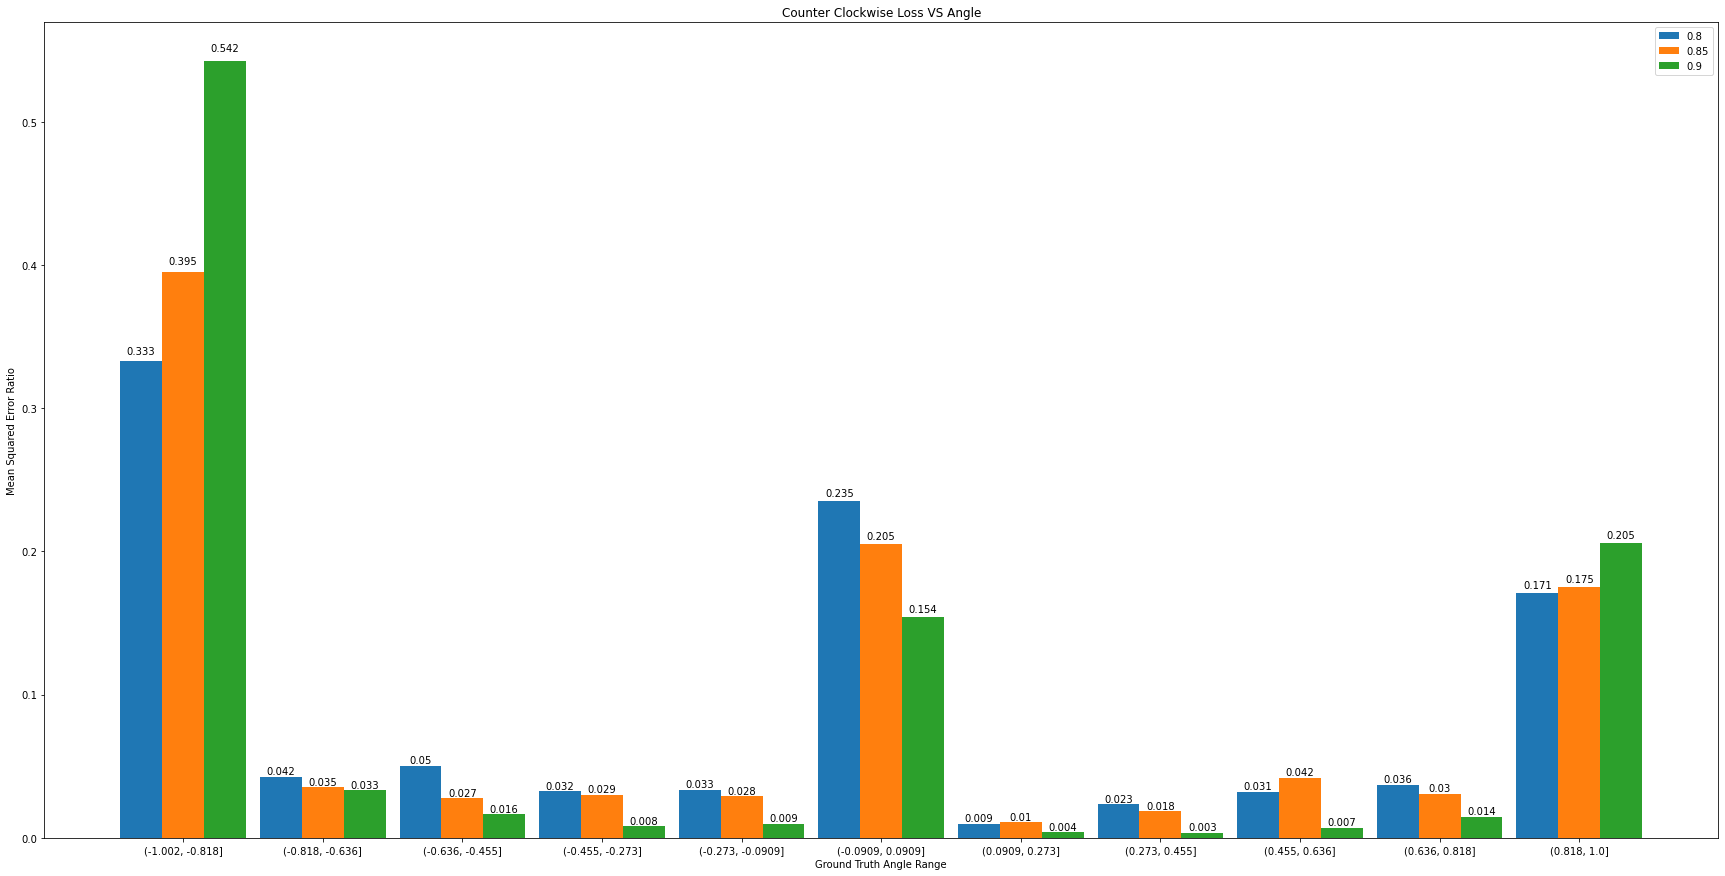

In [44]:

def plot_angle_vs_error_ratios(df: pd.DataFrame, direction: str):
    plt.figure(figsize=(30,15))
    ind = np.arange(df.gt_bin.unique().size)
    width = 0.3

    for i, speed in enumerate([0.8, 0.85, 0.9]):
        speed_df = df[df.speed == speed]
        total_sum = speed_df.squared_error.sum()
        grouped = speed_df.groupby('gt_bin')
        group_sum = grouped.squared_error.sum()
        squared_error_ratios = group_sum / total_sum
        rects = plt.bar(i*width+ind, squared_error_ratios, label=speed, width=width)
        autolabel(rects)

    plt.xlabel('Ground Truth Angle Range')
    plt.ylabel('Mean Squared Error Ratio')
    plt.title(f'{direction} Loss VS Angle')

    plt.xticks(ind + width, squared_error_ratios.index)
    plt.legend(loc='best')
    plt.show()

plot_angle_vs_error_ratios(cc_df, 'Counter Clockwise')

#### Conclusion
Yes, for slower speeds, the error is bigger for smaller angles, not far-right (+1) or far-left (-1).
The error is bigger for 0.9-speed for the maximum angle values, both, far-right and far-left.